In [1]:
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTENC, SMOTE
import pandas as pd
import numpy as np

In [2]:
# --- 1. Load Data and handel imbalance ---
df_336 = pd.read_csv("UCI_336.csv")
df_857 = pd.read_csv("UCI_857.csv")
df_ckd = pd.read_csv("Chronic_Kidney_Disease_data.csv")

In [3]:
# --- 2. Harmonization and Feature Engineering ---
# Target Unification and Feature Renaming for D3
df_ckd = df_ckd.rename(columns={'Diagnosis': 'class', 'Age': 'age', 'SerumCreatinine': 'sc', 
                                'HemoglobinLevels': 'hemo', 'ProteinInUrine': 'al'})

# Derived Proxy Features for D3
df_ckd['htn'] = ((df_ckd['SystolicBP'] >= 140) | (df_ckd['DiastolicBP'] >= 90)).astype(int)
df_ckd['dm'] = ((df_ckd['FastingBloodSugar'] >= 126) | (df_ckd['HbA1c'] >= 6.5)).astype(int)

# Define Feature Sets
features_m1 = ['age', 'htn', 'dm', 'cad', 'su', 'sg', 'al', 'bp', 'sc', 'hemo', 'rbcc']
features_m2 = ['age', 'htn', 'dm', 'cad', 'su', 'sg', 'al', 'sc', 'gfr', 'hemo', 'rbcc']
features_m3 = ['age', 'htn', 'dm', 'sc', 'GFR', 'hemo', 'al',
               'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c',
               'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'ACR']

data_dict = {
    'df_336': {'df': df_336, 'features': features_m1, 'target': 'class'},
    'df_857': {'df': df_857, 'features': features_m2, 'target': 'class'},
    'df_ckd': {'df': df_ckd, 'features': features_m3, 'target': 'class'}
}
split_data = {}

In [4]:
# --- 3. Data Splitting and Scaling ---
for name, data in data_dict.items():
    df, features, target = data['df'], data['features'], data['target']
    
    # 3A: Split
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
    )
    
    # 3B: Handle Class Imbalance
    if name == 'df_336':
        cat_features_336 = ['htn', 'dm', 'cad', 'su', 'al'] 
        cat_indices = [X_train.columns.get_loc(col) for col in cat_features_336 if col in X_train.columns]
        
        class_counts = y_train.value_counts()
        
        minority_count = class_counts.min()
        majority_count = class_counts.max()
        current_ratio = minority_count / majority_count
        
        if current_ratio < 0.5:
            target_ratio = 0.7  
        else:
            target_ratio = 'auto' 
        
        smotenc = SMOTENC(
            categorical_features=cat_indices, 
            sampling_strategy=target_ratio,
            k_neighbors=min(5, minority_count - 1), 
            random_state=42
        )
        X_train, y_train = smotenc.fit_resample(X_train, y_train)
                
    elif name == 'df_857':
        cat_features_857 = ['htn', 'dm', 'cad', 'su', 'al']
        cat_indices = [X_train.columns.get_loc(col) for col in cat_features_857 if col in X_train.columns]
        
        class_counts = y_train.value_counts()
        
        minority_count = class_counts.min()
        majority_count = class_counts.max()
        current_ratio = minority_count / majority_count
        
        if current_ratio < 0.5:
            target_ratio = 0.7
        else:
            target_ratio = 'auto'
        
        smotenc = SMOTENC(
            categorical_features=cat_indices, 
            sampling_strategy=target_ratio,
            k_neighbors=min(5, minority_count - 1),
            random_state=42
        )
        X_train, y_train = smotenc.fit_resample(X_train, y_train)
              
    elif name == 'df_ckd':
        class_counts = y_train.value_counts()
        
        minority_count = class_counts.min()
        majority_count = class_counts.max()
        current_ratio = minority_count / majority_count
        
        if current_ratio < 0.5:
            target_ratio = 0.7
        else:
            target_ratio = 'auto'  
        
        smote = SMOTE(
            sampling_strategy=target_ratio,
            k_neighbors=min(5, minority_count - 1),
            random_state=42
        )
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
           
    # Identify numerical columns for scaling
    binary_cols = ['htn', 'dm', 'cad']
    cols_to_scale = [col for col in X_train.columns if col not in binary_cols and X_train[col].dtype in [np.float64, np.int64]]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()
    X_train_scaled.loc[:, cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
    X_test_scaled.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    split_data[name] = {
        'X_train': X_train_scaled, 'X_test': X_test_scaled, 'y_train': y_train, 'y_test': y_test
    }

In [5]:
# --- 4. Base Model Training with Imbalance Handling ---
common_features = ['age', 'sc', 'hemo', 'dm', 'htn', 'al']
X_train_ckd = split_data['df_ckd']['X_train']
y_train_ckd = split_data['df_ckd']['y_train']
X_test_ckd = split_data['df_ckd']['X_test']
y_test_ckd = split_data['df_ckd']['y_test']

# M1: SVC (Balanced, trained on D1 common features)
svc_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf']
}
svc_grid = GridSearchCV(
    SVC(probability=True, random_state=42, class_weight='balanced'),
    svc_params, cv=5, scoring='balanced_accuracy',  # Changed from 'f1'
    n_jobs=-1, verbose=0
)
svc_grid.fit(split_data['df_336']['X_train'][common_features], split_data['df_336']['y_train'])
svc_optimized = svc_grid.best_estimator_

# M2: Random Forest (Balanced, trained on D2 common features)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    rf_params, cv=5, scoring='balanced_accuracy',  # Changed from 'f1'
    n_jobs=-1, verbose=0
)
rf_grid.fit(split_data['df_857']['X_train'][common_features], split_data['df_857']['y_train'])
rf_optimized = rf_grid.best_estimator_

# M3: XG Boost (trained on D3 full features)
scale_pos_weight_value = (y_train_ckd == 0).sum() / (y_train_ckd == 1).sum()

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, scale_pos_weight_value, scale_pos_weight_value * 2]  
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_params, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=0
)
xgb_grid.fit(X_train_ckd, y_train_ckd)
xgb_optimized = xgb_grid.best_estimator_


In [6]:
# --- 5. Generate Meta-Features (Training and Test Sets) ---
X_train_ckd_common = X_train_ckd[common_features]
X_test_ckd_common = X_test_ckd[common_features]

# Training Meta-Features
m1_train_proba = svc_optimized.predict_proba(X_train_ckd_common)[:, 1]
m2_train_proba = rf_optimized.predict_proba(X_train_ckd_common)[:, 1]
m3_train_proba = xgb_optimized.predict_proba(X_train_ckd)[:, 1] 
X_meta_train = pd.DataFrame({'M1_Proba': m1_train_proba, 'M2_Proba': m2_train_proba, 'M3_Proba': m3_train_proba})

# Test Meta-Features
m1_test_proba = svc_optimized.predict_proba(X_test_ckd_common)[:, 1]
m2_test_proba = rf_optimized.predict_proba(X_test_ckd_common)[:, 1]
m3_test_proba = xgb_optimized.predict_proba(X_test_ckd)[:, 1]
X_meta_test = pd.DataFrame({'M1_Proba': m1_test_proba, 'M2_Proba': m2_test_proba, 'M3_Proba': m3_test_proba})


In [7]:
def custom_cost_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Cost calculation
    fn_cost = 1  # Missing a CKD patient
    fp_cost = 2  # Wrongly diagnosing healthy person
    
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    
    return -total_cost

cost_scorer = make_scorer(custom_cost_score, greater_is_better=True)

In [8]:
# --- 6. Meta-Learner Training (Level 1) ---
# Tuned and Balanced Logistic Regression
meta_params = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', {0: 2, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}]
}

meta_grid = GridSearchCV(
    LogisticRegression(solver='lbfgs', random_state=42),
    meta_params,
    cv=5,
    scoring=cost_scorer, 
    n_jobs=-1
)

meta_grid.fit(X_meta_train, y_train_ckd)
meta_learner_tuned_balanced = meta_grid.best_estimator_

print(f"Best Meta-Learner Params: {meta_grid.best_params_}")


Best Meta-Learner Params: {'C': 0.1, 'class_weight': 'balanced'}


Base Models: SVC (D1), Random Forest (D2), XGBoost (D3)
Meta-Learner: Tuned Logistic Regression (C=1, class_weight='balanced')
Optimal Threshold: 0.9113

Accuracy:          0.8404
Balanced Accuracy: 0.7443
Precision:         0.9632
Recall:            0.8590
F1 Score:          0.9081
ROC AUC:           0.7155


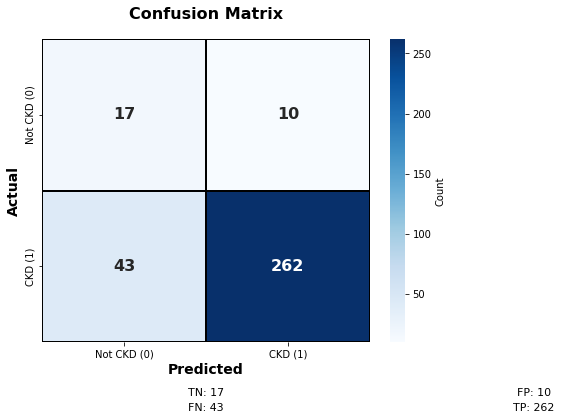

In [9]:
# --- 7. Final Evaluation ---
y_pred_proba_final = meta_learner_tuned_balanced.predict_proba(X_meta_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_ckd, y_pred_proba_final)
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

y_pred_final = (y_pred_proba_final >= optimal_threshold).astype(int)

# Calculate ALL metrics
accuracy_final = accuracy_score(y_test_ckd, y_pred_final)
precision_final = precision_score(y_test_ckd, y_pred_final)
recall_final = recall_score(y_test_ckd, y_pred_final)
f1_final = f1_score(y_test_ckd, y_pred_final)
roc_auc_final = roc_auc_score(y_test_ckd, y_pred_proba_final)
balanced_accuracy_final = balanced_accuracy_score(y_test_ckd, y_pred_final)
cm_final = confusion_matrix(y_test_ckd, y_pred_final)

tn, fp, fn, tp = cm_final.ravel()

# --- Output Results ---
print("="*70)
print(f"Base Models: SVC (D1), Random Forest (D2), XGBoost (D3)")
print(f"Meta-Learner: Tuned Logistic Regression (C=1, class_weight='balanced')")
print("="*70)
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"\nAccuracy:          {accuracy_final:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_final:.4f}") 
print(f"Precision:         {precision_final:.4f}")
print(f"Recall:            {recall_final:.4f}")
print(f"F1 Score:          {f1_final:.4f}")
print(f"ROC AUC:           {roc_auc_final:.4f}")
print("="*70)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not CKD (0)', 'CKD (1)'], 
            yticklabels=['Not CKD (0)', 'CKD (1)'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black',
            annot_kws={'size': 16, 'weight': 'bold'})

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', 
          fontsize=16, fontweight='bold', pad=20)

plt.text(0.5, -0.15, f'TN: {tn}', ha='center', va='top', transform=plt.gca().transAxes, fontsize=11)
plt.text(1.5, -0.15, f'FP: {fp}', ha='center', va='top', transform=plt.gca().transAxes, fontsize=11)
plt.text(0.5, -0.20, f'FN: {fn}', ha='center', va='top', transform=plt.gca().transAxes, fontsize=11)
plt.text(1.5, -0.20, f'TP: {tp}', ha='center', va='top', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.show()